In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import random
from collections import Counter
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Sample text corpus
corpus = """Natural language processing has improved significantly with transformer models.
 Large language models like GPT can generate human-like text.
 Attention mechanisms help models focus on relevant parts of the input.
 Transformers have revolutionized machine translation and text generation.
 The self-attention mechanism is a key innovation in transformer architectures.
 Tokenization is the first step in processing text for language models.
 Neural networks learn to represent words as vectors in a continuous space.
 Contextual embeddings capture word meaning based on surrounding context.
 Training language models requires large amounts of text data.
 Language models can be fine-tuned for specific tasks like summarization."""
 # Clean the text
corpus = corpus.strip().lower()
sentences = [s.strip() for s in corpus.split('.') if s.strip()]
print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

Number of sentences: 10
Sample sentence: natural language processing has improved significantly with transformer models


In [ ]:
import re

class WordTokenizer:
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0

    def fit(self, texts):
        """Build vocabulary from a list of texts"""
        words = set()
        for i in range(len(texts)):
            texts[i] = re.sub(r'[^\w\s]', '', texts[i])  # remove punctuation

        for text in texts:
            for word in text.split():
                words.add(word)

        sorted_words = sorted(list(words))
        self.word_to_idx = {word: idx for idx, word in enumerate(sorted_words)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(sorted_words)
        return self

    def encode(self, text):
        """Convert text to token indices (word-level)"""
        text = re.sub(r'[^\w\s]', '', text)
        return [self.word_to_idx[word] for word in text.split() if word in self.word_to_idx]

    def decode(self, indices):
        """Convert token indices back to text (word-level)"""
        return ' '.join([self.idx_to_word[idx] for idx in indices])

    def __len__(self):
        return self.vocab_size
tokenizer = WordTokenizer().fit(sentences)
print(f"Vocabulary size: {len(tokenizer)}")

sample_text = sentences[0]
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)

print(f"Original: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Vocabulary size: 72
Original: natural language processing has improved significantly with transformer models
Encoded: [41, 32, 47, 22, 26, 53, 69, 65, 40]
Decoded: natural language processing has improved significantly with transformer models


In [ ]:
def prepare_data(sentences, tokenizer, seq_length=20):
  """Prepare input-output pairs for training"""
  inputs = []
  targets = []

  for sentence in sentences:
      # Skip sentences that are too short
      if len(sentence) <= seq_length + 1:
          continue

      # Tokenize the sentence
      tokens = tokenizer.encode(sentence)

      # Create input-target pairs with a sliding window
      for i in range(len(tokens) - seq_length):
          input_seq = tokens[i:i+seq_length]
          target_seq = tokens[i+1:i+seq_length+1]  # Next token prediction

          inputs.append(input_seq)
          targets.append(target_seq)

  # Convert to PyTorch tensors
  inputs = torch.tensor(inputs, dtype=torch.long)
  targets = torch.tensor(targets, dtype=torch.long)

  return inputs, targets
# Prepare training data
seq_length = 10
inputs, targets = prepare_data(sentences, tokenizer, seq_length)
print(f"Number of training examples: {len(inputs)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
# Sample data point
idx = 0
print(f"Sample input: {tokenizer.decode(inputs[idx].tolist())}")
print(f"Sample target: {tokenizer.decode(targets[idx].tolist())}")

Number of training examples: 4
Input shape: torch.Size([4, 10])
Target shape: torch.Size([4, 10])
Sample input: attention mechanisms help models focus on relevant parts of the
Sample target: mechanisms help models focus on relevant parts of the input


In [ ]:
class EmbeddingLayer(nn.Module):
  def __init__(self, vocab_size, embed_dim):
      super(EmbeddingLayer, self).__init__()
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      self.embed_dim = embed_dim

  def forward(self, x):
    # x shape: (batch_size, seq_length)
      # output shape: (batch_size, seq_length, embed_dim)
      return self.embedding(x) * (self.embed_dim ** 0.5)  # Scaling factor
# Test the embedding layer
vocab_size = len(tokenizer)
embed_dim = 32
embedding_layer = EmbeddingLayer(vocab_size, embed_dim)
sample_batch = inputs[:3]  # Take 3 examples
embedded = embedding_layer(sample_batch)
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Embedded output shape: {embedded.shape}")

Sample batch shape: torch.Size([3, 10])
Embedded output shape: torch.Size([3, 10, 32])


Shape after positional encoding: torch.Size([3, 10, 32])


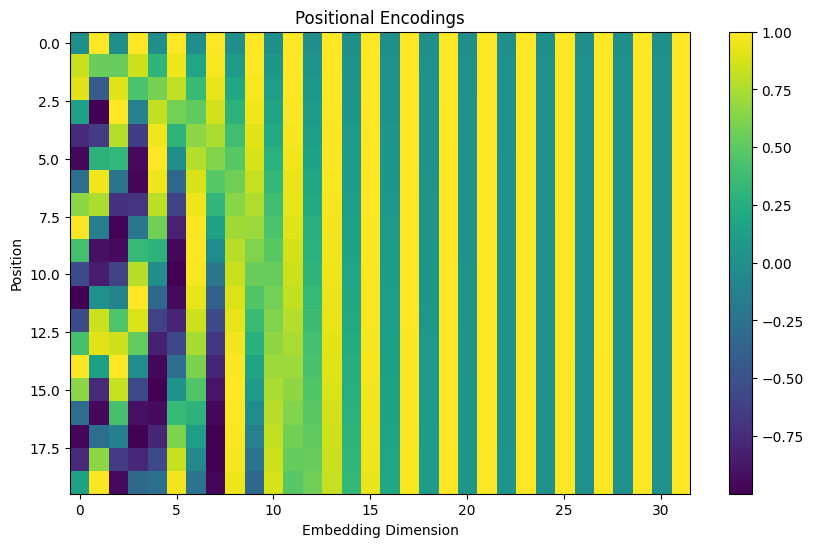

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, embed_dim, max_seq_length=5000):
      super(PositionalEncoding, self).__init__()

      # Create positional encoding matrix
      pe = torch.zeros(max_seq_length, embed_dim)
      position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))

      # Apply sine to even indices
      pe[:, 0::2] = torch.sin(position * div_term)
      # Apply cosine to odd indices
      pe[:, 1::2] = torch.cos(position * div_term)

      # Register as buffer (not model parameter)
      self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
      # x shape: (batch_size, seq_length, embed_dim)
      # Add positional encoding
      return x + self.pe[:, :x.size(1), :]
# Test positional encoding
pos_encoding = PositionalEncoding(embed_dim)
embedded_with_pos = pos_encoding(embedded)
print(f"Shape after positional encoding: {embedded_with_pos.shape}")
# Visualize positional encodings
plt.figure(figsize=(10, 6))
plt.imshow(pos_encoding.pe[0, :20, :].cpu().numpy(), aspect='auto', cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encodings')
plt.show()

Attention output shape: torch.Size([1, 10, 32])
Attention weights shape: torch.Size([1, 4, 10, 10])


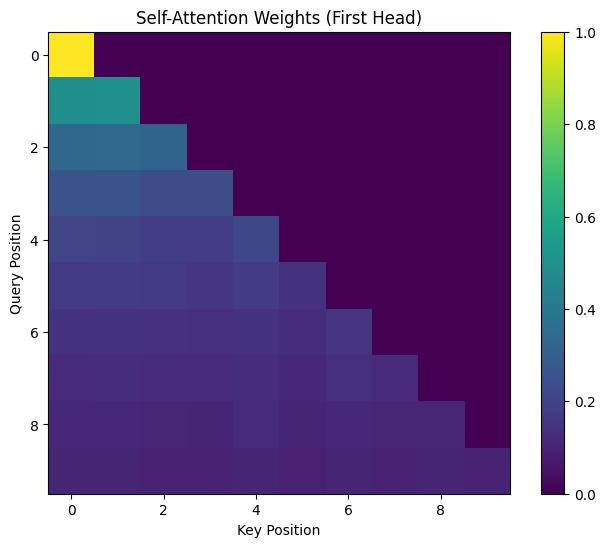

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.size()

        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        # Split into heads
        queries = queries.view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        keys = keys.view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        values = values.view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Scaled dot-product attention
        energy = torch.matmul(queries, keys.transpose(-1, -2)) / (self.head_dim ** 0.5)

        if mask is not None:
            mask = mask.to(energy.device)  # Ensure mask and energy are on the same device
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(energy, dim=-1)
        out = torch.matmul(attention, values)

        out = out.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_length, self.embed_dim)
        out = self.fc_out(out)

        return out, attention


# Create a causal mask for autoregressive attention
def create_causal_mask(seq_length):
    mask = torch.tril(torch.ones(seq_length, seq_length, device=device))
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)


# ------------------------- Testing -------------------------

# Dummy data
batch_size = 1
seq_length = 10
embed_dim = 32
num_heads = 4

# Random input tensor
embedded_with_pos = torch.rand(batch_size, seq_length, embed_dim).to(device)

# Create attention module and mask
attention = SelfAttention(embed_dim, num_heads).to(device)
mask = create_causal_mask(seq_length)

# Forward pass
attention_output, attention_weights = attention(embedded_with_pos, mask)

# Print shapes
print(f"Attention output shape: {attention_output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

# Plot attention weights for the first head
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0, 0].detach().cpu().numpy(), cmap='viridis')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()
plt.title('Self-Attention Weights (First Head)')
plt.show()


In [ ]:
class FeedForward(nn.Module):
  def __init__(self, embed_dim, ff_dim):
      super(FeedForward, self).__init__()
      self.fc1 = nn.Linear(embed_dim, ff_dim)
      self.fc2 = nn.Linear(ff_dim, embed_dim)
      self.activation = nn.GELU()  # GELU activation as used in modern transformers

  def forward(self, x):
      # x shape: (batch_size, seq_length, embed_dim)
      x = self.fc1(x)  # (batch_size, seq_length, ff_dim)
      x = self.activation(x)
      x = self.fc2(x)  # (batch_size, seq_length, embed_dim)
      return x
# Test feed-forward network
ff_dim = embed_dim * 4  # Common practice to use 4x the embedding dimension
feed_forward = FeedForward(embed_dim, ff_dim)
ff_output = feed_forward(attention_output)
print(f"Feed-forward output shape: {ff_output.shape}")

Feed-forward output shape: torch.Size([1, 10, 32])


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN before Self-Attention
        norm_x = self.norm1(x)
        attn_output, _ = self.attention(norm_x, mask)
        x = x + self.dropout(attn_output)

        # Pre-LN before Feed Forward
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)

        return x


In [ ]:
class MiniLanguageModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_seq_length, dropout=0.1):
      super(MiniLanguageModel, self).__init__()

      self.embed_dim = embed_dim
      self.embedding = EmbeddingLayer(vocab_size, embed_dim)
      self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)

      self.transformer_blocks = nn.ModuleList(
          [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
      )

      self.fc_out = nn.Linear(embed_dim, vocab_size)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      # Create causal mask
      seq_length = x.shape[1]
      mask = create_causal_mask(seq_length).to(x.device)

      # Embedding and positional encoding
      x = self.embedding(x)
      x = self.positional_encoding(x)
      x = self.dropout(x)

      # Transformer blocks
      for block in self.transformer_blocks:
          x = block(x, mask)

      # Output layer
      x = self.fc_out(x)  # (batch_size, seq_length, vocab_size)

      return x
# Model hyperparameters
vocab_size = len(tokenizer)
embed_dim = 64
num_heads = 4
ff_dim = embed_dim * 4
num_layers = 6
max_seq_length = 100
dropout = 0.1
# Initialize the model
model = MiniLanguageModel(
  vocab_size=vocab_size,
  embed_dim=embed_dim,
  num_heads=num_heads,
  ff_dim=ff_dim,
  num_layers=num_layers,
  max_seq_length=max_seq_length,
  dropout=dropout
).to(device)
# Print model summary
print(model)
# Test forward pass
sample_batch = inputs[:5].to(device)  # Take 5 examples
output = model(sample_batch)
print(f"Model output shape: {output.shape}")  # Should be (batch_size, seq_length, vocab_size

MiniLanguageModel(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(72, 64)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): SelfAttention(
        (query): Linear(in_features=64, out_features=64, bias=True)
        (key): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc_out): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (activation): GELU(approximate='none')
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=64, out_features=72, bias=True)
  (

Epoch 1/10, Batch 0/1, Loss: 11.8008
Epoch 1/10, Average Loss: 11.8008
Epoch 2/10, Batch 0/1, Loss: 9.0370
Epoch 2/10, Average Loss: 9.0370
Epoch 3/10, Batch 0/1, Loss: 6.3171
Epoch 3/10, Average Loss: 6.3171
Epoch 4/10, Batch 0/1, Loss: 4.6279
Epoch 4/10, Average Loss: 4.6279
Epoch 5/10, Batch 0/1, Loss: 3.5948
Epoch 5/10, Average Loss: 3.5948
Epoch 6/10, Batch 0/1, Loss: 2.3707
Epoch 6/10, Average Loss: 2.3707
Epoch 7/10, Batch 0/1, Loss: 1.4787
Epoch 7/10, Average Loss: 1.4787
Epoch 8/10, Batch 0/1, Loss: 0.9529
Epoch 8/10, Average Loss: 0.9529
Epoch 9/10, Batch 0/1, Loss: 0.6311
Epoch 9/10, Average Loss: 0.6311
Epoch 10/10, Batch 0/1, Loss: 0.3193
Epoch 10/10, Average Loss: 0.3193


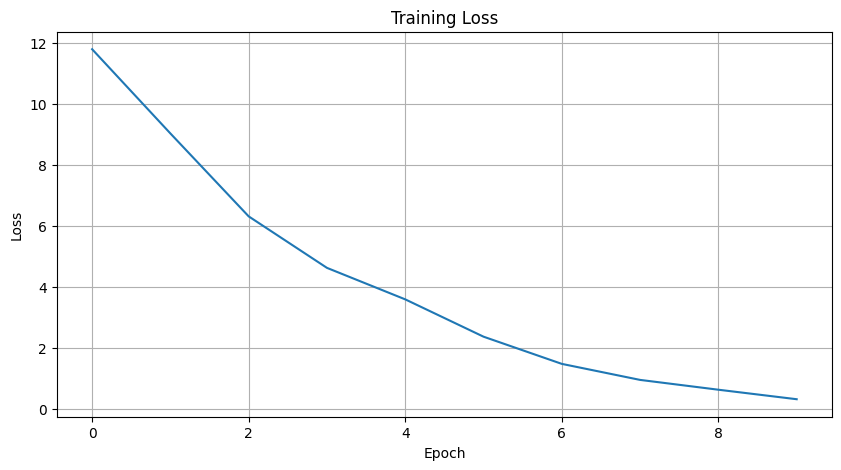

In [ ]:
def train_model(model, inputs, targets, batch_size=64, epochs=10, lr=3e-4):
  """Train the language model"""
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

  # Create dataset and dataloader
  dataset = torch.utils.data.TensorDataset(inputs, targets)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Training loop
  model.train()
  losses = []

  for epoch in range(epochs):
      epoch_loss = 0
      for batch_idx, (batch_inputs, batch_targets) in enumerate(dataloader):
          batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

          # Forward pass
          optimizer.zero_grad()
          outputs = model(batch_inputs)

          # Reshape outputs and targets for loss computation
          outputs = outputs.reshape(-1, vocab_size)  # (batch_size * seq_length, vocab_size)
          batch_targets = batch_targets.reshape(-1)  # (batch_size * seq_length)

          # Compute loss
          loss = criterion(outputs, batch_targets)

          # Backward pass and optimization
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
          optimizer.step()

          epoch_loss += loss.item()

          if batch_idx % 10 == 0:
              print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

      avg_epoch_loss = epoch_loss / len(dataloader)
      losses.append(avg_epoch_loss)
      print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

  return losses
# For the lab, we'll use a very small number of epochs
epochs = 10
batch_size = 16
losses = train_model(model, inputs, targets, batch_size=batch_size, epochs=epochs)
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0):
  """Generate text using the trained model"""
  model.eval()

  # Tokenize the prompt
  prompt_tokens = tokenizer.encode(prompt)
  input_ids = torch.tensor(prompt_tokens).unsqueeze(0).to(device)  # (1, prompt_length)

  # Generate text
  generated = list(prompt_tokens)

  with torch.no_grad():
      for _ in range(max_length):
          # Take the last seq_length tokens if input is too long
          if input_ids.size(1) > seq_length:
              input_ids = input_ids[:, -seq_length:]

          # Forward pass
          outputs = model(input_ids)

          # Get the next token probabilities
          next_token_logits = outputs[:, -1, :] / temperature

          # Sample from the distribution
          probs = F.softmax(next_token_logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)

          # Add the next token to the sequence
          input_ids = torch.cat([input_ids, next_token], dim=1)
          generated.append(next_token.item())

          # Stop if we generate the end of sentence token (if you have one)
          # if next_token.item() == eos_token_id:
          #     break

  # Convert back to text
  generated_text = tokenizer.decode(generated)

  return generated_text
# Generate text
prompt = "language models"
generated_text = generate_text(
  model=model,
  tokenizer=tokenizer,
  prompt=prompt,
  max_length=8,
  temperature=0.4
)
print(f"Prompt: {prompt}")
print(f"Generated text: {generated_text}")

Prompt: language models
Generated text: language models focus on relevant parts of the first step


In [ ]:
import pandas as pd
dic={'optimizer':['Adam','Rmsprop','Adam'],'epochs':[3,5,10],'num_layers':[2,5,6],'loss':[8.1432,1.5042,7.2331]}
pd.DataFrame(dic)

,optimizer,epochs,num_layers,loss
0,Adam,3,2,8.1432
1,Rmsprop,5,5,1.5042
2,Adam,10,6,7.2331
